## IMPORTS

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import itertools
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

EPOCHS = 100
LR = 0.0005
BS = 64
num_classes = 10 
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

## DATA LOADING AND PREPROCESSING

In [2]:
dataset = tf.keras.datasets.cifar10
(x_train  , y_train) , (x_test , y_test)  = dataset.load_data()
x_train.shape , y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [3]:
x_train = x_train /255 
x_test = x_test/255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                 zoom_range=0.05,
                                                                 width_shift_range=0.05 ,
                                                                 height_shift_range=0.05)
train_generator = data_generator.flow(x_train, y_train, BS)
spe = x_train.shape[0] // BS

## MODEL DESIGN

In [5]:
base_model = tf.keras.applications.ResNet101V2(include_top=False,weights="imagenet",input_shape=x_train.shape[1:] )
model= tf.keras.Sequential()
model.add(base_model) 
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(1024,activation=('relu'))) 
model.add(Dropout(.2))
model.add(Dense(num_classes,activation=('softmax')))
model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 1, 1, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 44,734,986
Trainable params: 44,637,322
Non-trainable params: 97,664
_______________________________________

## TRAINING

In [6]:
ES = tf.keras.callbacks.EarlyStopping("val_accuracy" ,0,5 ,restore_best_weights=True)
r = model.fit(train_generator , validation_data=(x_test , y_test), steps_per_epoch = spe ,epochs=EPOCHS ,callbacks = [ES] )

  ...
    to  
  ['...']
Train for 781 steps, validate on 10000 samples
Epoch 1/100
781/781 [==============================] - 118s 151ms/step - loss: 2.0028 - accuracy: 0.2722 - val_loss: 2.0879 - val_accuracy: 0.3586
Epoch 2/100
781/781 [==============================] - 103s 132ms/step - loss: 1.3446 - accuracy: 0.5362 - val_loss: 1.1316 - val_accuracy: 0.6227
Epoch 3/100
781/781 [==============================] - 102s 131ms/step - loss: 1.0781 - accuracy: 0.6459 - val_loss: 1.3463 - val_accuracy: 0.6039
Epoch 4/100
781/781 [==============================] - 104s 133ms/step - loss: 0.9700 - accuracy: 0.6834 - val_loss: 1.1169 - val_accuracy: 0.6744
Epoch 5/100
781/781 [==============================] - 103s 132ms/step - loss: 0.8548 - accuracy: 0.7227 - val_loss: 0.8438 - val_accuracy: 0.7152
Epoch 6/100
781/781 [==============================] - 101s 129ms/step - loss: 0.7898 - accuracy: 0.7444 - val_loss: 1.0014 - val_accuracy: 0.6712
Epoch 7/100
781/781 [=========================

## PLOTS

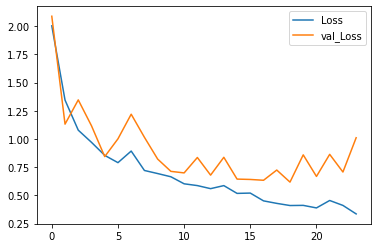

In [7]:
plt.plot(r.history["loss"], label= "Loss")
plt.plot(r.history["val_loss"], label = "val_Loss")
plt.legend();

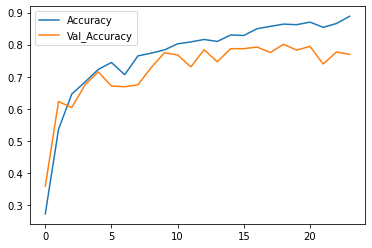

In [8]:
plt.plot(r.history["accuracy"] ,label = "Accuracy")
plt.plot(r.history["val_accuracy"] ,label = "Val_Accuracy")
plt.legend();

## TEST SCORE

In [14]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 10s 978us/sample - loss: 0.6178 - accuracy: 0.8011
Test accuracy: 0.8011


## PREDICTIONS

In [10]:
preds = model.predict(x_test) 
y_preds = np.argmax(preds, axis=1) 
y_true = np.argmax(y_test, axis=1)

### CLASSIFICATION REPORT

In [11]:
print(classification_report(y_true , y_preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.83      0.93      0.88      1000
           2       0.67      0.81      0.73      1000
           3       0.69      0.61      0.65      1000
           4       0.86      0.69      0.76      1000
           5       0.74      0.72      0.73      1000
           6       0.83      0.89      0.86      1000
           7       0.86      0.86      0.86      1000
           8       0.95      0.81      0.87      1000
           9       0.83      0.87      0.85      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



### CONFUSION MATRIX

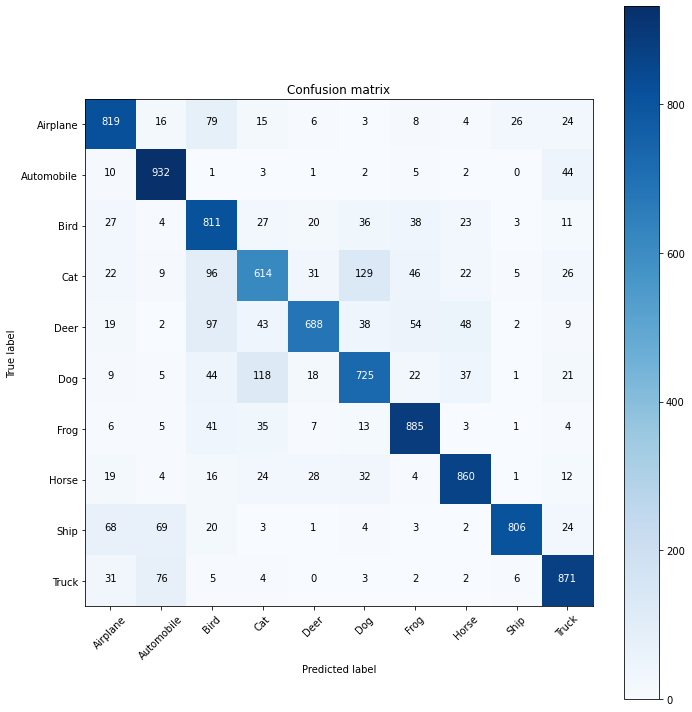

In [12]:
plt.rcParams["figure.figsize"] = (10,10)
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
      This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
cm = confusion_matrix(y_true, y_preds)
plot_confusion_matrix(cm , classes)

In [13]:
model.save("models/Saved_model.h5")